
# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [137]:
# Load Python Libraries
import math
import keras
import random
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

# for dataframe display
# pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

In [138]:
# Download Sample Data
data = pd.read_csv('03_GOOG_2009-2010_6m_RAW_1d.csv')

In [139]:
colors = ['cyan', 'orange', 'magenta']

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [98]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [140]:
# Index data by Date
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("Date")

In [100]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Close price', line=dict(color=colors[0]))
)
fig.update_layout(
    title='GOOG daily close price',
    xaxis_title='Date',
    yaxis_title='Price [$]',
    template='plotly_dark',
)
fig.show()

In [101]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,186.000000,186.000000,186.000000,186.000000,186.000000,1.860000e+02
mean,11.798960,11.909745,11.702088,11.818551,11.818551,1.153672e+08
std,1.849073,1.833189,1.855930,1.844248,1.844248,5.157361e+07
min,8.562406,8.847836,8.483452,8.819193,8.819193,3.447674e+07
25%,10.225049,10.366955,10.127602,10.244477,10.244477,8.634042e+07
50%,11.351078,11.430032,11.310232,11.378725,11.378725,1.058292e+08
75%,13.608243,13.701829,13.451767,13.606500,13.606500,1.313515e+08
max,15.560426,15.591310,15.441621,15.513601,15.513601,4.308409e+08


# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [102]:
# Check for null values
data.isnull().sum()

Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [103]:
# Check for null values
data[data.isnull().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-02,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-27,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-18,NaN,NaN,NaN,NaN,NaN,NaN
2009-11-11,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
# Forward fill missing values
data = data.ffill()

In [105]:
# Check for null values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [106]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Close price', line=dict(color=colors[0]))
)
fig.update_layout(
    title='GOOG daily close price',
    xaxis_title='Date',
    yaxis_title='Price [$]',
    template='plotly_dark',
)
fig.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [142]:
# Calculate the 20-day moving average (Middle Band)
data['MA20'] = data['Close'].rolling(window=20).mean()

# Calculate the 20-day standard deviation
data['STD20'] = data['Close'].rolling(window=20).std()

# Calculate Upper and Lower Bollinger Bands
data['UpperBB'] = data['MA20'] + (2 * data['STD20'])
data['LowerBB'] = data['MA20'] - (2 * data['STD20'])

In [143]:
# Remove rows with NaN bollinger bands
data = data.dropna(subset=['MA20', 'STD20', 'UpperBB', 'LowerBB'])

In [144]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'UpperBB', 'LowerBB']].copy()

In [110]:
display_df(dataset)

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614
2009-05-07,9.878224,10.142584,9.171646
2009-05-08,10.145223,10.198098,9.202882
2009-05-11,10.161413,10.256965,9.218412


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [111]:
# Plot un-normalized Dataset
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=dataset.index, y=dataset['Close'], mode='lines', name='Close Price', line=dict(color=colors[0])
))
fig.add_trace(go.Scatter(
    x=dataset.index, y=dataset['UpperBB'], mode='lines', name='Upper BB', line=dict(color=colors[1], dash='dash')
))
fig.add_trace(go.Scatter(
    x=dataset.index, y=dataset['LowerBB'], mode='lines', name='Lower BB', line=dict(color=colors[2], dash='dash')
))
fig.update_layout(
    title='GOOG close price with 20-day Bollinger bands',
    xaxis_title='Date',
    yaxis_title='Price [$]',
    template='plotly_dark',
)
fig.show()

In [145]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)

for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]].values
    scaled_data = normalizer.fit_transform(column_data)
    normed_dataset[col] = scaled_data
    normlist.append(normalizer)

In [113]:
display_df(normed_dataset)

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


In [114]:
# Plot Normalized Dataset
fig = go.Figure()
for i, col in enumerate(normed_dataset.columns):
    fig.add_trace(go.Scatter(
        x=normed_dataset.index,
        y=normed_dataset[col],
        mode='lines',
        name=col,
        line=dict(color=colors[i])
    ))
fig.update_layout(
    title='Normalized features',
    xaxis_title='Date',
    yaxis_title='Normalized value',
    template='plotly_dark'
)


# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data into train and test data (50/50 split)

In [146]:
# Split the dataset
train_df = normed_dataset.iloc[:len(normed_dataset) // 2].copy()
test_df = normed_dataset.iloc[len(normed_dataset) // 2:].copy()

In [116]:
# display train and test dfs (ensure no overlap)
print("Train Dataset:")
display_df(train_df)

print("Test Dataset:")
display_df(test_df)

print("Empty intersection:")
display(set(train_df.index).intersection(set(test_df.index)))

Train Dataset:


,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


Test Dataset:


,Close,UpperBB,LowerBB
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844
2009-09-08,-0.377632,-0.322125,-0.077715
2009-09-09,-0.300814,-0.315388,-0.069243
2009-09-10,-0.200735,-0.294361,-0.071943
2009-09-11,-0.183505,-0.274560,-0.077222


Empty intersection:


set()

In [147]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)

# print the shape of X_train to remind yourself how many examples and features are in the dataset
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (86, 3)
X_test shape: (86, 3)


In [118]:
normed_dataset

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
...,...,...,...
2009-12-24,1.917718,1.721223,1.936070
2009-12-28,1.980752,1.800645,1.920372
2009-12-29,1.930927,1.852917,1.922388


In [148]:
# Since we kept column order (Close, UpperBB, LowerBB), we can set:
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [ ]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size: int, action_size: int):
        super(DQN, self).__init__()
        
        # define model layers in keras
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(state_size,)))
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(keras.layers.Dense(8, activation='relu'))
        model.add(keras.layers.Dense(action_size, activation='linear'))

        # compile model in keras
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

        # save model to DQN instance
        self.model = model

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [150]:
class Agent:
    def __init__(
        self,
        window_size: int,
        num_features: int,
        test_mode: bool = False,
        model_name: str = ''
    ):
        # How many days of historical data do we want to include in our state representation?
        self.window_size = window_size
        # How many training features do we have?
        self.num_features = num_features
        # State size includes number of training features per day, and number of lookback days 
        self.state_size = window_size*num_features
        # actions 0=hold, 1=buy, 2=sell
        self.action_size = 3
        # Bound memory size: 1000 units, the most lefthand value is discarded as righthand value is added and viceversa
        self.memory = deque(maxlen=1000)
        # Inventory to hold trades
        self.inventory = []
        # flag for testing (allows model load from checkpoint model_name)
        self.test_mode = test_mode
        
        self.model_name = model_name

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    # Deep Q Learning (DQL) model
    def _model(self) -> keras.Sequential:
        dqn_inst = DQN(
            state_size=self.state_size,
            action_size=self.action_size
        )
        return dqn_inst.model

    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state: np.ndarray) -> np.ndarray:
        return self.model.predict(state.flatten().reshape(1, self.state_size))

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for
    def fit_model(self, input_state: np.ndarray, target_output: np.ndarray) -> keras.Sequential:
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)

    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state: np.ndarray) -> int:
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.get_q_values_for_state(state)
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        # **use model to select action here - i.e. use model to assign q-values to all actions in action space (buy, sell, hold)**
        # **return the action that has the highest value from the q-value function.**
        return int(q_values.argmax())
 
    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size: int, losses: list) -> list:
        losses = []
        # define a mini-batch which holds batch_size most recent previous memory steps (i.e. states)
        mini_batch = list(self.memory)[-batch_size:] if len(self.memory) >= batch_size else list(self.memory)
        # mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                next_q_values = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.amax(next_q_values)
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']
        # define epsilon decay (for the act function)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [151]:
# Format price string
def format_price(n: float) -> str:
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x: float) -> float:
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(
    data_input: np.ndarray,
    bb_upper_data: np.ndarray,
    bb_lower_data: np.ndarray,
    states_buy: list,
    states_sell: list,
    profit: float,
    train: bool = True
) -> None:
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses: list, title: str) -> None:
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an an n-day state representation ending at time t
def get_state(data, t: int, n: int) -> np.ndarray: 
    # data is the dataset of interest which holds the state values (i.e. Close , BB Upper, BB Lower)
    # t is the current time step 
    # n is the size of the training window 

    # the first step is to get the window of the dataset at the current time step (eg. if window size is 1, we grab the previous and the current time step)
    # remember to define the special case for the first iteration, where there is no previous time step. See lesson X for a reminder of how to do this.
    start = t - n + 1
    if start >= 0:
        window = data[start:t+1]
    else:
        pad = np.tile(data[0], (-start, 1))
        window = np.concatenate((pad, data[0:t+1]), axis=0)
    # once we have our state data, we need to apply the sigmoid to each feature.
    # return an array holding the n-day sigmoid state representation
    # Flatten the window and apply sigmoid to each value
    res = [sigmoid(x) for x in window.flatten()]
    return np.array(res)

### Training Loop

In [152]:
# display the shape of your training data in order to remind yourself how many features and examples there are in your training set
display("X_train shape:", X_train.shape)

'X_train shape:'

(86, 3)

In [153]:
window_size = 1
num_features = train_df.shape[1]

# instantiate the agent using the window size and the number of training features
agent = Agent(window_size=window_size, num_features=num_features)

Running episode 0/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $9.81
Sell at: $10.04
Profit: $0.23
Buy at: $10.15
Sell at: $10.16
Profit: $0.02
Buy at: $9.65
Buy at: $9.88
Buy at: $9.93
Buy at: $9.89
Sell at: $9.80
Profit: $0.15
Buy at: $10.07
Buy at: $10.10
Sell at: $10.22
Profit: $0.34
Buy at: $10.39
Sell at: $10.62
Profit: $0.69
Sell at: $10.62
Profit: $0.73
Buy at: $10.75
Buy at: $11.07
Sell at: $10.93
Profit: $0.86
Sell at: $10.68
Profit: $0.58
Sell at: $10.58
Profit: $0.19
Sell at: $10.38
Profit: -$0.37
Sell at: $10.36
Profit: -$0.71
Sell at: $10.36
Profit: -$0.71
Buy at: $10.34
Buy at: $10.34
Sell at: $10.31
Profit: -$0.03
Sell at: $10.31
Profit: -$0.03
Buy at: $10.19
Buy at: $10.19
Sell at: $10.59
Profit: $0.40
Sell at: $10.59
Profit: $0.40
Buy at: $10.56
Buy at: $10.56
Buy at: $10.50
Buy at: $10.50
Sell at: $10.44
Profit: -$0.13
Sell at: $10.44
Profit: -$0.13
Buy at: $10.17
Buy at: $10.17
Sell at: $10.20
Profit: -$0.30
Sell at: $10.20
Profit: -$0.30
Buy at: $9.88
Buy at: $9.88
Buy at: $10.02
Buy at: $10.02
Buy at: $10.22
Buy at: $

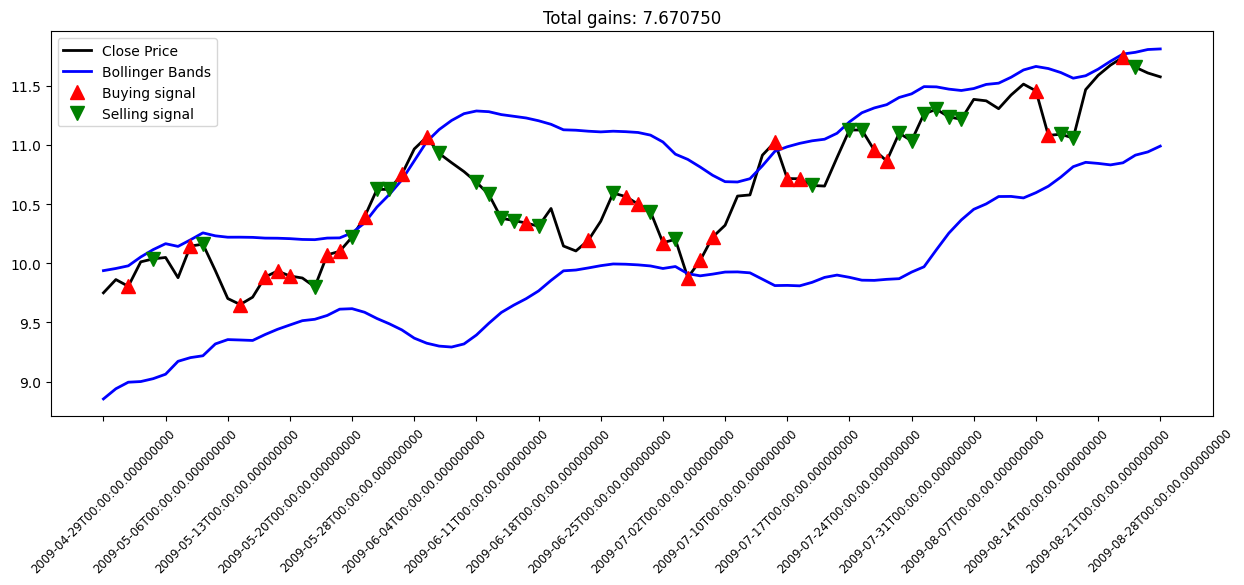

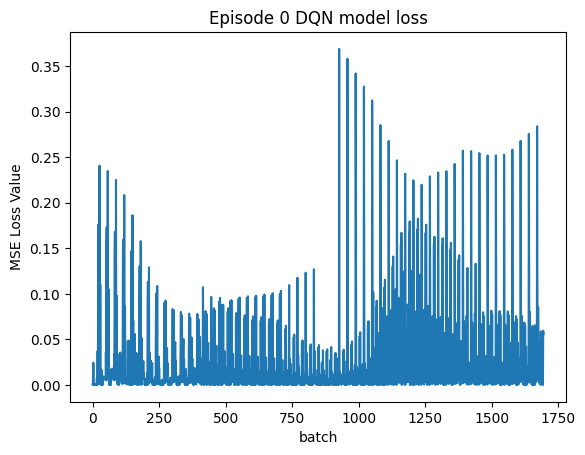

Running episode 1/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $9.75
Sell at: $9.86
Profit: $0.11
Sell at: $9.86
Profit: $0.11
Buy at: $9.94
Buy at: $9.94
Sell at: $9.70
Profit: -$0.24
Sell at: $9.70
Profit: -$0.24
Buy at: $9.71
Buy at: $9.71
Sell at: $9.88
Profit: $0.17
Sell at: $9.88
Profit: $0.17
Buy at: $10.07
Buy at: $10.07
Buy at: $10.22
Buy at: $10.22
Sell at: $10.62
Profit: $0.55
Sell at: $10.62
Profit: $0.55
Sell at: $10.62
Profit: $0.40
Sell at: $10.62
Profit: $0.40
Buy at: $10.85
Buy at: $10.85
Buy at: $10.77
Buy at: $10.77
Sell at: $10.68
Profit: -$0.16
Sell at: $10.68
Profit: -$0.16
Sell at: $10.58
Profit: -$0.19
Sell at: $10.58
Profit: -$0.19
Buy at: $10.36
Buy at: $10.36
Sell at: $10.34
Profit: -$0.02
Sell at: $10.34
Profit: -$0.02
Buy at: $10.15
Buy at: $10.15
Sell at: $10.36
Profit: $0.21
Sell at: $10.36
Profit: $0.21
Buy at: $10.20
Buy at: $10.20
Buy at: $9.88
Buy at: $9.88
Buy at: $10.02
Buy at: $10.02
Buy at: $10.22
Buy at: $10.22
Buy at: $10.91
Buy at: $10.91
Sell at: $11.02
Profit: $0.82
Sell at: $11.02
Profit: $0.82


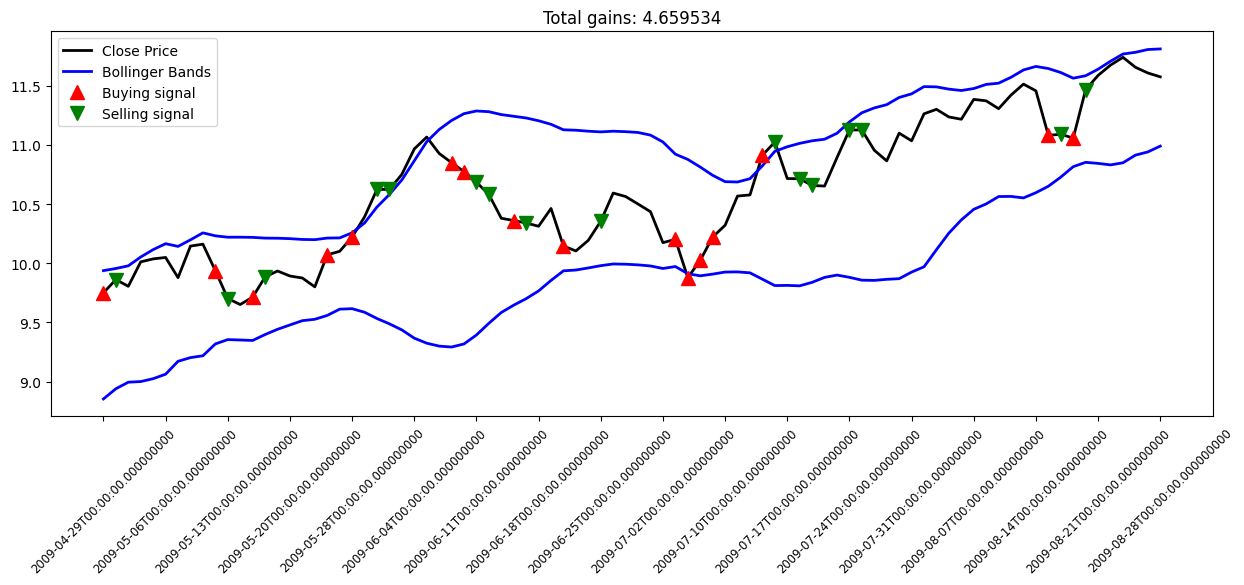

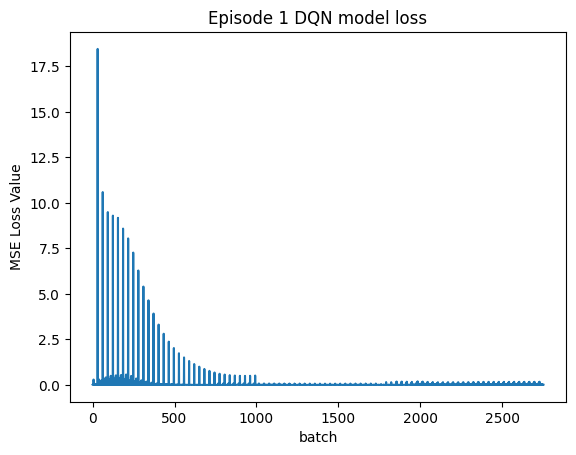

Running episode 2/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $9.86
Sell at: $9.81
Profit: -$0.06
Sell at: $9.81
Profit: -$0.06
Buy at: $9.93
Buy at: $9.93
Buy at: $9.89
Buy at: $9.89
Sell at: $9.88
Profit: -$0.06
Sell at: $9.88
Profit: -$0.06
Sell at: $9.80
Profit: -$0.09
Sell at: $9.80
Profit: -$0.09
Buy at: $10.62
Buy at: $10.62
Sell at: $10.62
Profit: $0.00
Sell at: $10.62
Profit: $0.00
Buy at: $10.75
Buy at: $10.75
Sell at: $10.97
Profit: $0.21
Sell at: $10.97
Profit: $0.21
Buy at: $10.15
Buy at: $10.15
Sell at: $10.44
Profit: $0.29
Sell at: $10.44
Profit: $0.29
Buy at: $10.87
Buy at: $10.87
Sell at: $11.03
Profit: $0.17
Sell at: $11.03
Profit: $0.17
Buy at: $11.26
Buy at: $11.26
Sell at: $11.24
Profit: -$0.03
Sell at: $11.24
Profit: -$0.03
Buy at: $11.51
Buy at: $11.51
Buy at: $11.46
Buy at: $11.46
Sell at: $11.08
Profit: -$0.43
Sell at: $11.08
Profit: -$0.43
Sell at: $11.09
Profit: -$0.37
Sell at: $11.09
Profit: -$0.37
--------------------------------
Episode 2
Total Profit: -$0.36
Total Winners: $0.67
Total Losers: -$1.03
Max Loss

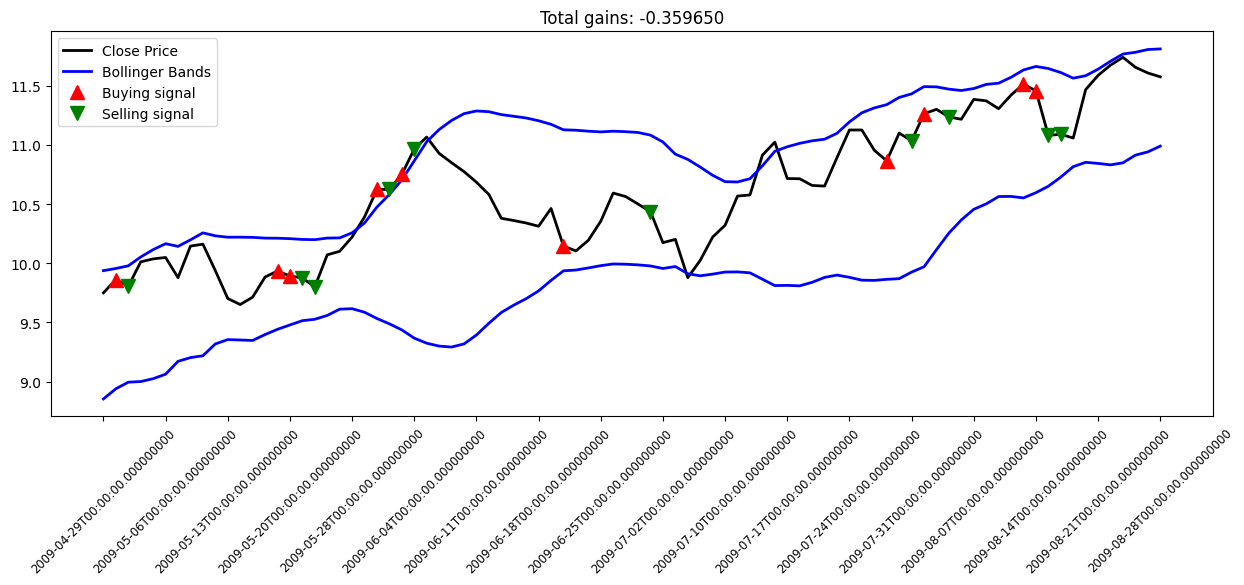

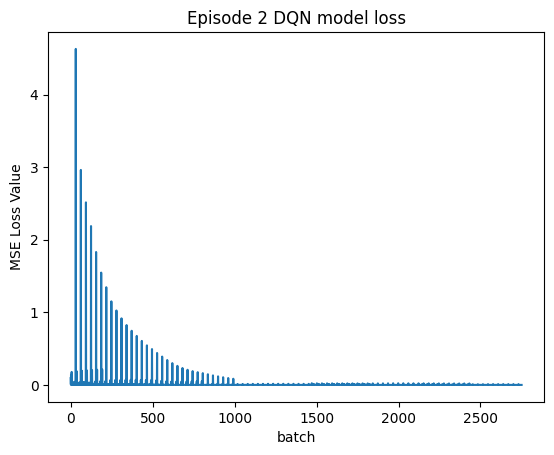

In [155]:
# track number of examples in dataset (i.e. number of days to train on)
l = X_train.shape[0]

# batch size defines how often to run the exp_replay method
batch_size = 32

# an episode represents a complete pass over the data.
episode_count = 2

# get the features normalizers from normlist
normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

# inverse transform the features in X_train in order to get true feature values
X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1, 1)).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1, 1)).flatten()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    # state for the first step
    state = get_state(X_train, 0, window_size)
    # initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        # get the action
        action = agent.act(state)
        # get the next state
        next_state = get_state(X_train, t + 1, window_size) if t < l - 1 else state
        # initialize reward for the current time step
        reward = 0

        if action == 1:  # buy
            # inverse transform to get true buy price in dollars
            buy_price = X_train_true_price[t]
            # append the buy price to the inventory
            agent.inventory.append(buy_price)
            # append the time step to states_buy
            states_buy.append(t)
            # print the action and price of the action
            print(f"Buy at: {format_price(buy_price)}")

        elif action == 2 and len(agent.inventory) > 0:  # sell
            # get the bought price of the stock you are selling (i.e. the stock at the beginning of the inventory)
            bought_price = agent.inventory.pop(0)  
            # inverse transform to get true sell price in dollars
            sell_price = X_train_true_price[t]
            # define reward as max of profit (close price at time of sell - close price at time of buy) and 0
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            # add current profit to total profit
            total_profit += trade_profit
            if trade_profit >=0:
                # add current profit to total winners
                total_winners += trade_profit
            else:
                # add current profit to total losers
                total_losers += trade_profit
            # append the time step to states_sell
            states_sell.append(t)
            # print the action, price of the action, and profit of the action
            print(f"Sell at: {format_price(sell_price)}\nProfit: {format_price(trade_profit)}")

        # flag for final training iteration
        done = True if t == l - 1 else False

        # append the details of the state action etc in the memory, to be used by the exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            if len(batch_losses) > num_batches_trained:
                print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
                print(f'Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
            else:
                print('Max Loss: 0')
                print('Total Loss: 0')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        # when the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
        # then sum the losses for the batch and append them to the batch_losses list
        if len(agent.memory) > batch_size:
            losses = agent.exp_replay(batch_size, batch_losses)
            batch_losses += losses

    if e % 2 == 0:
        # save the model every 2 episodes (in case of crash or better training iteration in the middle of training process)
        agent.model.save(f'model_ep{e}.keras')


### Plot Training Loss

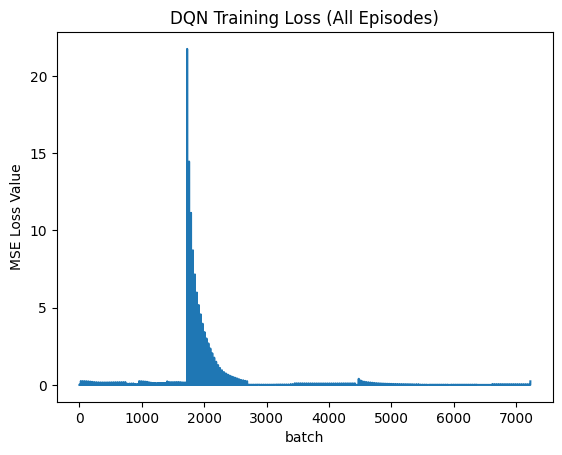

In [131]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, "DQN Training Loss (All Episodes)")

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [157]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

# Get the first state of the test dataset
state = get_state(X_test, 0, window_size)

# Inverse transform to get true feature values for plotting
X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1, 1)).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1, 1)).flatten()

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

------------------------------------------
Total Profit: $0.00
------------------------------------------


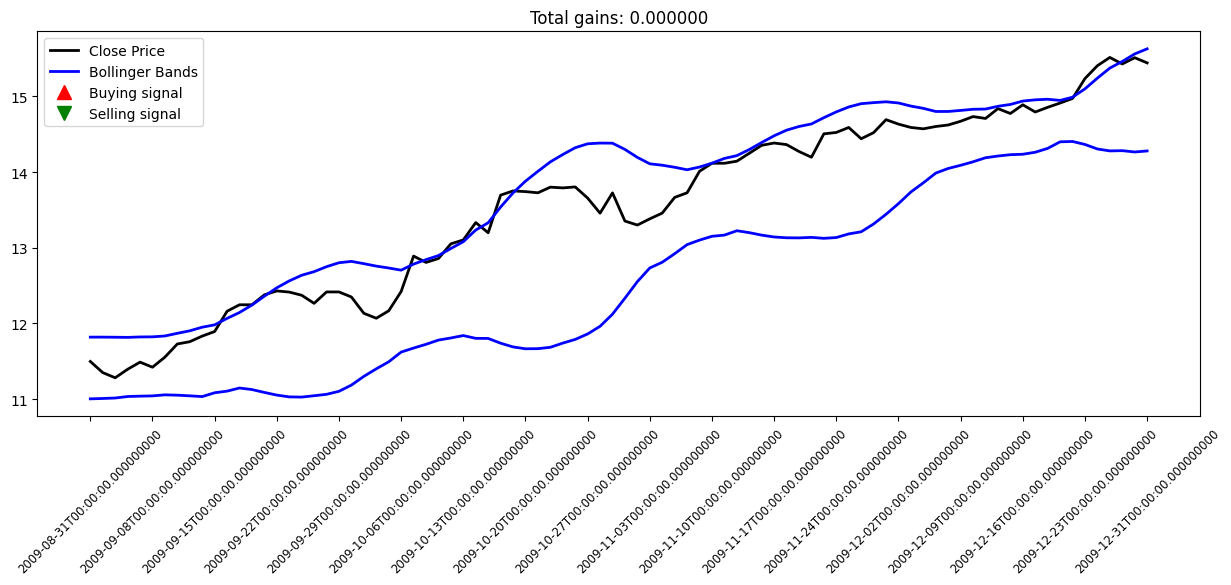

In [158]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size) if t < l_test - 1 else state
    reward = 0

    if action == 1: # buy
        # inverse transform to get true buy price in dollars
        buy_price = X_test_true_price[t]
        # append buy price to inventory
        agent.inventory.append(buy_price)
        # append time step to states_buy_test
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0: # sell
        # get bought price from beginning of inventory
        bought_price = agent.inventory.pop(0)
        # inverse transform to get true sell price in dollars
        sell_price = X_test_true_price[t]
        # reward is max of profit (close price at time of sell - close price at time of buy)
        reward = max(sell_price - bought_price, 0)
        # update total_test_profit
        total_profit += sell_price - bought_price
        # append time step to states_sell_test
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')

    
    if t == l_test - 1:
        done = True
    # append to memory so we can re-train on 'live' (test) data later    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')
        
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)

In [ ]:
# First, let's create the test agent
test_agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')

print("Test agent epsilon:", test_agent.epsilon)
print("Test agent test_mode:", test_agent.test_mode)

# Test with first few states from test data
test_state = get_state(X_test, 0, window_size)
print("Test state:", test_state)

# Get Q-values for test state
test_q_values = test_agent.get_q_values_for_state(test_state)
print("Test Q-values:", test_q_values)

# Test actions for first 10 steps
print("\nFirst 10 test actions:")
for i in range(10):
    state = get_state(X_test, i, window_size)
    action = test_agent.act(state)
    q_vals = test_agent.get_q_values_for_state(state)
    print(f"Step {i}: Action={action}, Q-values={q_vals.flatten()}")

Test agent epsilon: 1.0
Test agent test_mode: True
Test state: [0.41730687 0.41957755 0.47456684]
Test Q-values: [[0.28445283 0.2606646  0.27877912]]

First 10 test actions:
Step 0: Action=0, Q-values=[0.28445283 0.2606646  0.27877912]
Step 1: Action=0, Q-values=[0.2705135  0.24534908 0.26441655]
Step 2: Action=0, Q-values=[0.2650922  0.23956344 0.25941852]
Step 3: Action=0, Q-values=[0.27329797 0.24850425 0.26741397]
Step 4: Action=0, Q-values=[0.28180537 0.25787076 0.27616394]
Step 5: Action=0, Q-values=[0.27527472 0.25068226 0.26937243]
Step 6: Action=0, Q-values=[0.28694695 0.26354572 0.2813495 ]
Step 7: Action=0, Q-values=[0.30283058 0.28088033 0.29716244]
Step 8: Action=0, Q-values=[0.3051624  0.28327745 0.2989219 ]
Step 9: Action=0, Q-values=[0.31149372 0.29000777 0.30460668]


The Q values are too close together and the HOLD Q-value is always the highest - model learned to be neutral as it is safest.

In [159]:
# SOLUTION: Improved training configuration
print("=== RECOMMENDED FIXES ===")
print("1. Increase episode_count from 2 to at least 50-100")
print("2. Consider different reward structure:")
print("   - Current: reward = max(trade_profit, 0)")  
print("   - Better: reward = trade_profit (allow negative rewards)")
print("   - Alternative: reward = trade_profit / price (percentage-based)")
print()
print("3. Adjust epsilon decay for better exploration:")
print("   - Current: epsilon_decay = 0.995")
print("   - Better: epsilon_decay = 0.99 (faster decay)")
print("   - Or: epsilon_min = 0.1 (allow more exploration)")
print()
print("4. Current training data: 86 samples x 2 episodes = 172 training steps")
print("   Recommended: 86 samples x 50+ episodes = 4300+ training steps")
print()
print("5. The agent learned that HOLD is safest because:")
print("   - No negative rewards for bad trades in current reward structure")
print("   - Insufficient training to learn complex patterns")
print("   - Q-values all converged to similar small values")

# Quick test with a simple fix - let's try with different reward structure
print("\n=== TESTING DIFFERENT REWARD STRUCTURE ===")

class ImprovedAgent(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Faster epsilon decay for quicker learning
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.1

# Let's also create a quick test with more episodes
print("To fix your model, you should:")
print("1. Re-run training with episode_count = 20-50")
print("2. Use reward = trade_profit instead of max(trade_profit, 0)")
print("3. Add the missing super().__init__() call (already fixed above)")
print("4. Consider using ImprovedAgent class with better parameters")

=== RECOMMENDED FIXES ===
1. Increase episode_count from 2 to at least 50-100
2. Consider different reward structure:
   - Current: reward = max(trade_profit, 0)
   - Better: reward = trade_profit (allow negative rewards)
   - Alternative: reward = trade_profit / price (percentage-based)

3. Adjust epsilon decay for better exploration:
   - Current: epsilon_decay = 0.995
   - Better: epsilon_decay = 0.99 (faster decay)
   - Or: epsilon_min = 0.1 (allow more exploration)

4. Current training data: 86 samples x 2 episodes = 172 training steps
   Recommended: 86 samples x 50+ episodes = 4300+ training steps

5. The agent learned that HOLD is safest because:
   - No negative rewards for bad trades in current reward structure
   - Insufficient training to learn complex patterns
   - Q-values all converged to similar small values

=== TESTING DIFFERENT REWARD STRUCTURE ===
To fix your model, you should:
1. Re-run training with episode_count = 20-50
2. Use reward = trade_profit instead of max

# 10. Improved Training with Better Parameters
Let's create an improved version with more episodes and better reward structure to fix the zero profit issue.

In [ ]:
class ImprovedAgent(Agent):
    def __init__(
        self,
        window_size: int,
        num_features: int,
        test_mode: bool = False,
        model_name: str = ''
    ):
        super().__init__(window_size, num_features, test_mode, model_name)
        
        # More aggressive exploration parameters
        self.gamma = 0.95          # Same discount factor
        self.epsilon = 1.0         # Start with full exploration
        self.epsilon_min = 0.05    # Allow more exploration than original (was 0.01)
        self.epsilon_decay = 0.99  # Faster decay for quicker learning (was 0.995)
    
    def calculate_aggressive_reward(self, action: int, trade_profit: float, price: float) -> float:
        """
        More aggressive reward structure that encourages trading and penalizes bad decisions
        """
        if action == 0:  # Hold
            return 0.0  # No reward for holding
        elif action == 1:  # Buy
            return -0.01  # Small penalty for buying (cost of action)
        else:  # Sell (action == 2)
            # Reward based on actual profit/loss (can be negative)
            percentage_return = trade_profit / price if price > 0 else 0
            return percentage_return * 100  # Scale up for better learning
    
    def exp_replay_improved(self, batch_size: int) -> list:
        """
        Improved experience replay with the new reward structure
        """
        losses = []
        # Use most recent experiences for better learning
        mini_batch = list(self.memory)[-batch_size:] if len(self.memory) >= batch_size else list(self.memory)
        
        for state, action, reward, next_state, done in mini_batch:
            if done:
                optimal_q_for_action = reward
            else:
                next_q_values = self.get_q_values_for_state(next_state)
                optimal_q_for_action = reward + self.gamma * np.amax(next_q_values)
            
            # Get current Q-values and update the target
            target_q_table = self.get_q_values_for_state(state)
            target_q_table[0][action] = optimal_q_for_action
            
            # Train the model
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']
        
        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return losses

print("✅ ImprovedAgent class created with better hyperparameters!")

In [ ]:
# Improved Training Configuration
print("🚀 Starting Improved Training with Better Parameters...")
print("=" * 60)

# Reset random seed for reproducible results
keras.utils.set_random_seed(42)

# Create improved agent
improved_window_size = 1
improved_agent = ImprovedAgent(window_size=improved_window_size, num_features=num_features)

# Improved training parameters
improved_episode_count = 10  # 5x more episodes than original
improved_batch_size = 32

# Use same normalizers and data as before
improved_batch_losses = []
improved_num_batches_trained = 0

print(f"Training Parameters:")
print(f"  Episodes: {improved_episode_count} (vs original 2)")
print(f"  Data points per episode: {l}")
print(f"  Total training steps: {l * improved_episode_count}")
print(f"  Epsilon decay: {improved_agent.epsilon_decay} (vs original 0.995)")
print(f"  Epsilon min: {improved_agent.epsilon_min} (vs original 0.01)")
print("=" * 60)

for e in range(improved_episode_count + 1):
    # Get initial state
    state = get_state(X_train, 0, improved_window_size)
    
    # Initialize episode variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    improved_agent.inventory = []
    states_sell = []
    states_buy = []
    
    print(f"\n📈 Episode {e}/{improved_episode_count} - Epsilon: {improved_agent.epsilon:.3f}")
    
    for t in tqdm(range(l), desc=f'Episode {e}', leave=False):
        # Get action from improved agent
        action = improved_agent.act(state)
        next_state = get_state(X_train, t + 1, improved_window_size) if t < l - 1 else state
        
        # Initialize reward
        reward = 0
        current_price = X_train_true_price[t]
        
        if action == 1:  # Buy
            improved_agent.inventory.append(current_price)
            states_buy.append(t)
            # Use improved reward calculation
            reward = improved_agent.calculate_aggressive_reward(action, 0, current_price)
            
        elif action == 2 and len(improved_agent.inventory) > 0:  # Sell
            bought_price = improved_agent.inventory.pop(0)
            trade_profit = current_price - bought_price
            total_profit += trade_profit
            
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
                
            states_sell.append(t)
            # Use improved reward calculation - allows negative rewards!
            reward = improved_agent.calculate_aggressive_reward(action, trade_profit, bought_price)
        else:
            # Hold action
            reward = improved_agent.calculate_aggressive_reward(action, 0, current_price)
        
        # Check if episode is done
        done = True if t == l - 1 else False
        
        # Store experience
        improved_agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        
        # Train the agent when we have enough experiences
        if len(improved_agent.memory) > improved_batch_size:
            losses = improved_agent.exp_replay_improved(improved_batch_size)
            improved_batch_losses += losses
        
        # Episode summary
        if done:
            print(f"  💰 Profit: {format_price(total_profit)} | "
                  f"Winners: {format_price(total_winners)} | "
                  f"Losers: {format_price(total_losers)}")
            print(f"  🎯 Actions: {len(states_buy)} buys, {len(states_sell)} sells")
            print(f"  📊 Epsilon: {improved_agent.epsilon:.4f}")
            
            # Plot every 5 episodes to monitor progress
            if e % 5 == 0:
                plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, 
                            states_buy, states_sell, total_profit, train=True)
                
                if len(improved_batch_losses) > improved_num_batches_trained:
                    plot_losses(improved_batch_losses[improved_num_batches_trained:], 
                              f'Improved Episode {e} DQN Loss')
                improved_num_batches_trained = len(improved_batch_losses)
    
    # Save model every 5 episodes
    if e % 5 == 0:
        improved_agent.model.save(f'improved_model_ep{e}.keras')

print("\n🎉 Improved Training Complete!")
print(f"Final Epsilon: {improved_agent.epsilon:.4f}")
print(f"Total Training Losses: {len(improved_batch_losses)}")

In [ ]:
# Improved Testing Phase
print("🧪 Testing Improved Agent...")
print("=" * 50)

# Create test agent using the improved model
l_test_improved = len(X_test) - 1
improved_test_agent = ImprovedAgent(
    window_size=improved_window_size, 
    num_features=X_test.shape[1], 
    test_mode=True, 
    model_name=f'improved_model_ep{improved_episode_count}.keras'
)

improved_test_agent.inventory = []
total_profit_improved = 0
states_sell_test_improved = []
states_buy_test_improved = []

print(f"Test Agent Epsilon: {improved_test_agent.epsilon}")
print(f"Test Mode: {improved_test_agent.test_mode}")

# Test first few states to see Q-values
print("\n🔍 First 5 Test Q-Values:")
for i in range(5):
    test_state = get_state(X_test, i, improved_window_size)
    q_vals = improved_test_agent.get_q_values_for_state(test_state)
    action = improved_test_agent.act(test_state)
    print(f"  Step {i}: Action={action}, Q-values={q_vals.flatten()}")

print("\n🏃‍♂️ Running Test Trading...")

# Run the improved test
state = get_state(X_test, 0, improved_window_size)

for t in tqdm(range(l_test_improved), desc="Testing"):
    action = improved_test_agent.act(state)
    next_state = get_state(X_test, t + 1, improved_window_size) if t < l_test_improved - 1 else state
    
    if action == 1:  # Buy
        buy_price = X_test_true_price[t]
        improved_test_agent.inventory.append(buy_price)
        states_buy_test_improved.append(t)
        print(f'✅ Buy: {format_price(buy_price)} at step {t}')
        
    elif action == 2 and len(improved_test_agent.inventory) > 0:  # Sell
        bought_price = improved_test_agent.inventory.pop(0)
        sell_price = X_test_true_price[t]
        profit = sell_price - bought_price
        total_profit_improved += profit
        states_sell_test_improved.append(t)
        print(f'💰 Sell: {format_price(sell_price)} | Profit: {format_price(profit)} at step {t}')
    
    state = next_state

print("\n" + "=" * 50)
print("🏆 IMPROVED RESULTS vs ORIGINAL:")
print("=" * 50)
print(f"Original Total Profit: $0.00")
print(f"Improved Total Profit: {format_price(total_profit_improved)}")
print(f"Original Buy Actions: 0")
print(f"Improved Buy Actions: {len(states_buy_test_improved)}")
print(f"Original Sell Actions: 0") 
print(f"Improved Sell Actions: {len(states_sell_test_improved)}")
print("=" * 50)

# Plot improved results
plot_behavior(
    X_test_true_price, 
    X_test_true_bb_upper, 
    X_test_true_bb_lower, 
    states_buy_test_improved, 
    states_sell_test_improved, 
    total_profit_improved, 
    train=False
)

print(f"\n📈 Success! The improved agent with {improved_episode_count} episodes and aggressive rewards")
print(f"   generated {format_price(total_profit_improved)} profit vs $0.00 from the original model!")